## _"Texture Synthesis Using Convolutional Neural Networks" - Tensorflow implementation_

### In summary, we will try to generate texture based on the sample texture image from the scratch random noisy image.
Step 1: Preprocessing the input image

Step 2: Computing the output for all the layers for the input image.

Step 3: What is loss function in this problem and computing the loss function.

Step 4: Running Tensorflow model to minimize the loss and optimize the input noise variable.

Step 5: Post processing and displaying the image

Step 6: Automating the stuffs

Step 7: Plotting the successful results.

### Step 1: Preprocessing the input image

_Note: Here, we have used VGG16 layer instead of VGG19 layer (which was used in the paper.) but both can perform the job. Also, as suggested by the authors' of the paper, we have used average pooling instead of max pooling._

In [1]:
import numpy as np
import helper
import tf_helper
import tensorflow as tf

# Because we just want to compute output of convolution layers not fully connected layers,
# we can have any size of input image we want.

input_w = 256   # width of input image(original image will be scaled down to this width), width of generated image 
input_h = 256   # height of input image(original image will be scaled down to this height), height of generated image

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### The "helper.py" will help us preprocess and post process the input image. 

#### The "tf_helper.py" will help us compute all the layers-outputs of a given image from VGG16 network. This values will be used later in the actual session. 

In [2]:
input_file = "./image_resources/original/texture_9.jpg"
output_path = "./image_resources/processed/"
output_file = "Texture_9_processed.jpg"

# This will scale down the image to given width and height, save it and 
# scale its value to [0-1] as the model expects the input to be between o and 1
# Lastly, it will make a tensorflow ready numpy array with [1, w, h, 3] dims

texture_array = helper.resize_and_rescale_img(input_file, input_w, input_h, output_path, output_file)

### Step 2: Computing the output for all the layers for the input image. (This will be used later in loss function) 

In [3]:
# Here, we will compute the outputs of all the layers for the given texture image.

texture_outputs = tf_helper.compute_tf_output(texture_array)

D:\LEARN\Deep Learning\3. Style Transfer Paper implementations\Texture generation from Image using CNN\tensorflow_vgg\vgg16.npy
npy file loaded
build model started
build model finished: 0s
[]
All layers' outputs have been computed sucessfully.


### Step 3: What is loss function in this problem and computing the loss function.

#### Below, we will implement the actual equations of the paper.
#### 1. The first step is to understand Gram matrix and how to compute is.
So the gram matrix is matrix multiplication of filters of a given layer to itself. Still didn't get it. Ok.
Let's assume we are computing gram matrix for 2nd Convolutional Layer in VGG16 having 64 filters. So the output of that convolutional layer is in the shape of [1, 224, 224, 64]. Now we will squeeze its 0th axis and make it into [224, 224, 64] then we will convert 3D array into 2D array by reshaping into [224*224, 64] shape. Now our layer representation is in 2D form. 

layer_representation = array in [224*224, 64] shape

So our Gram Matrix = np.matmul(layer_representation.Transpose, layer_representation)

So our Gram Matrix will be of shape [64, 64]. As per its property the elements of layer_representation are linearly independed if the Gram Matrix value is non-zero. Also if the elements are coreleated to each other then the value of elements of Gram Matrix will be higher. Following extracts from the paper will help further understand it.

![](paper/snippet-1.png)
![](paper/snippet-2.png)

#### 2. Once we compute Gram Matrix, we'll compute loss function for a given layer.
The loss function for a given layer will be the difference between the Gram matrix of a given image for that layer and Gram matrix of a input noise for that layer. Also, the loss function can be weighted summation of losses of multiple layers. Also as directed by the paper, if we decide to compute the loss upto layer 2nd pooling layer then we will have to compute the loss for layers : _1st convolution layer, 2nd convolution layer, pooling layer-1, 3rd convolution layer, 4th convolution layer and pooling layer-2._
Also we can select individual layers rather than going in the ordered fashion.


![](paper/snippet-3.png)

In [4]:
def loss_function(m, texture_op, noise_layers):
    loss = tf.constant(0, dtype=tf.float32, name="Loss")

    for i in range(len(m)):
        texture_filters = np.squeeze(texture_op[m[i][0]], 0)
        texture_filters = np.reshape(texture_filters, newshape=(texture_filters.shape[0] * texture_filters.shape[1], texture_filters.shape[2]))
        gram_matrix_texture = np.matmul(texture_filters.T, texture_filters)

        noise_filters = tf.squeeze(noise_layers[m[i][0]], 0)
        noise_filters = tf.reshape(noise_filters, shape=(noise_filters.shape[0] * noise_filters.shape[1], noise_filters.shape[2]))
        gram_matrix_noise = tf.matmul(tf.transpose(noise_filters), noise_filters)

        denominator = (4 * tf.convert_to_tensor(texture_filters.shape[1], dtype=tf.float32) * tf.convert_to_tensor(texture_filters.shape[0], dtype=tf.float32))

        loss += m[i][1] * (tf.reduce_sum(tf.square(tf.subtract(gram_matrix_texture, gram_matrix_noise))) / tf.cast(denominator, tf.float32))
    
    return loss

### Step 4: Running Tensorflow model to minimize the loss and optimize the input noise variable.

In [5]:
from tensorflow_vgg import vgg16_avg_pool
tf.reset_default_graph()

vgg = vgg16_avg_pool.Vgg16()

# random_ = tf.truncated_normal(shape=content_array.shape, mean=0.5, stddev=0.5)

# Instead of truncated normal or random normal, it has been observed that the random_uniform is producing better results.

# random_ = tf.random_uniform(shape=texture_array.shape, minval=0, maxval=1)

# It has been observed after multiple attempts that minval = 0 and maxval = 0.2 gives better results

random_ = tf.random_uniform(shape=texture_array.shape, minval=0, maxval=0.2)

input_noise = tf.Variable(initial_value=random_, name='input_noise', dtype=tf.float32)

vgg.build(input_noise)

noise_layers_list = dict({0: vgg.conv1_1, 1: vgg.conv1_2, 2: vgg.pool1, 3: vgg.conv2_1, 4: vgg.conv2_2, 5: vgg.pool2, 6: vgg.conv3_1, 7: vgg.conv3_2, 
               8: vgg.conv3_3, 9: vgg.pool3, 10: vgg.conv4_1, 11: vgg.conv4_2, 12: vgg.conv4_3, 13: vgg.pool4, 14: vgg.conv5_1, 15: vgg.conv5_2, 
               16: vgg.conv5_3, 17: vgg.pool5 })

# m will be array of tuples with 2 elements inside. 
# 1st element will be layer no. and 2nd element will be weight assigned for the layer.
m = [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]

loss = loss_function(m, texture_outputs, noise_layers_list)

optimizer = tf.train.AdamOptimizer().minimize(loss)


epochs = 10000
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #print(tf.trainable_variables())
    init_noise = sess.run(input_noise)
    for i in range(epochs):
        _, s_loss = sess.run([optimizer, loss])
        if (i+1) % 100 == 0:
            print("Epoch: {}/{}".format(i+1, epochs), " Loss: ", s_loss)
    final_noise = sess.run(input_noise)

D:\LEARN\Deep Learning\3. Style Transfer Paper implementations\Texture generation from Image using CNN\tensorflow_vgg\vgg16.npy
npy file loaded
build model started
build model finished: 0s
Epoch: 100/10000  Loss:  5561466700000000.0
Epoch: 200/10000  Loss:  1723600700000000.0
Epoch: 300/10000  Loss:  1085700600000000.0
Epoch: 400/10000  Loss:  793587200000000.0
Epoch: 500/10000  Loss:  573624600000000.0
Epoch: 600/10000  Loss:  411701170000000.0
Epoch: 700/10000  Loss:  296650540000000.0
Epoch: 800/10000  Loss:  218586760000000.0
Epoch: 900/10000  Loss:  167589070000000.0
Epoch: 1000/10000  Loss:  134516260000000.0
Epoch: 1100/10000  Loss:  112711820000000.0
Epoch: 1200/10000  Loss:  97875090000000.0
Epoch: 1300/10000  Loss:  87305060000000.0
Epoch: 1400/10000  Loss:  79353830000000.0
Epoch: 1500/10000  Loss:  73012360000000.0
Epoch: 1600/10000  Loss:  67674634000000.0
Epoch: 1700/10000  Loss:  62971586000000.0
Epoch: 1800/10000  Loss:  58710173000000.0
Epoch: 1900/10000  Loss:  547408

### Step 5: Post processing and displaying the image

In [6]:
# Post process will convert the output of CNN from [1, w, h, 3] to [w, h, 3]. 
# Then it will normalize the values to [0-1] and then convert into [0-255] range.
# Lastly, it will display image and save the image at provided loaction.

output_directory = "./image_resources/outputs/"
initial_noise_file_name = "Texture_9_C3_noise.jpg"
final_noise_file_name = "Texture_9_C3_final.jpg"

initial_noise = helper.post_process_and_display(init_noise, output_directory, initial_noise_file_name, save_file=False)
final_noise_ = helper.post_process_and_display(final_noise, output_directory, final_noise_file_name)

#  ------------------------------------------------------------------------------------------------------------

### Step 6: Automating the stuffs
_Let's create a function to automate the things for us :-P_

In [9]:
from tensorflow_vgg import vgg16_avg_pool
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import helper
import tf_helper
import tensorflow as tf

def loss_function(m, texture_op, noise_layers):
    loss = tf.constant(0, dtype=tf.float32, name="Loss")

    for i in range(len(m)):
        texture_filters = np.squeeze(texture_op[m[i][0]], 0)
        texture_filters = np.reshape(texture_filters, newshape=(texture_filters.shape[0] * texture_filters.shape[1], texture_filters.shape[2]))
        gram_matrix_texture = np.matmul(texture_filters.T, texture_filters)

        noise_filters = tf.squeeze(noise_layers[m[i][0]], 0)
        noise_filters = tf.reshape(noise_filters, shape=(noise_filters.shape[0] * noise_filters.shape[1], noise_filters.shape[2]))
        gram_matrix_noise = tf.matmul(tf.transpose(noise_filters), noise_filters)

        denominator = (4 * tf.convert_to_tensor(texture_filters.shape[1], dtype=tf.float32) * tf.convert_to_tensor(texture_filters.shape[0], dtype=tf.float32))

        loss += m[i][1] * (tf.reduce_sum(tf.square(tf.subtract(gram_matrix_texture, gram_matrix_noise))) / tf.cast(denominator, tf.float32))
    
    return loss

def run_texture_synthesis(input_filename, processed_path, processed_filename, m, eps, op_dir, initial_filename, final_filename):
    i_w = 256   # width of input image(original image will be scaled down to this width), width of generated image 
    i_h = 256   # height of input image(original image will be scaled down to this height), height of generated image
    
    texture_array = helper.resize_and_rescale_img(input_filename, i_w, i_h, processed_path, processed_filename)
    texture_outputs = tf_helper.compute_tf_output(texture_array)
    
    tf.reset_default_graph()
    vgg = vgg16_avg_pool.Vgg16()

    random_ = tf.random_uniform(shape=texture_array.shape, minval=0, maxval=0.2)
    input_noise = tf.Variable(initial_value=random_, name='input_noise', dtype=tf.float32)

    vgg.build(input_noise)

    noise_layers_list = dict({0: vgg.conv1_1, 1: vgg.conv1_2, 2: vgg.pool1, 3: vgg.conv2_1, 4: vgg.conv2_2, 5: vgg.pool2, 6: vgg.conv3_1, 7: vgg.conv3_2, 
                   8: vgg.conv3_3, 9: vgg.pool3, 10: vgg.conv4_1, 11: vgg.conv4_2, 12: vgg.conv4_3, 13: vgg.pool4, 14: vgg.conv5_1, 15: vgg.conv5_2, 
                   16: vgg.conv5_3, 17: vgg.pool5 })

    loss = loss_function(m, texture_outputs, noise_layers_list)
    optimizer = tf.train.AdamOptimizer().minimize(loss)


    epochs = eps
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        print(tf.trainable_variables())
        init_noise = sess.run(input_noise)
        for i in range(epochs):
            _, s_loss = sess.run([optimizer, loss])
            if (i+1) % 1000 == 0:
                print("Epoch: {}/{}".format(i+1, epochs), " Loss: ", s_loss)
        final_noise = sess.run(input_noise)
    
    initial_noise = helper.post_process_and_display(init_noise, op_dir, initial_filename, save_file=False)
    final_noise_ = helper.post_process_and_display(final_noise, op_dir, final_filename)

### _Now let's generate samples based on different configurations of m array._

Here, we use m array as weights while summing the loss of different layers. We have generated results for following configurations for multiple different images. The configurations are as follows.
1. Configuration 1: 
    - Convolution Layer - 1_1 (Weight = 1)
2. Configuration 2: 
    - Convolution Layer - 1_1 (Weight = 1)
    - Convolution Layer - 1_2 (Weight = 1)
    - Pooling Layer - 1 (Weight = 1)
3. Configuration 3: 
    - Convolution Layer - 1_1 (Weight = 1)
    - Convolution Layer - 1_2 (Weight = 1)
    - Pooling Layer - 1 (Weight = 1)
    - Convolution Layer - 2_1 (Weight = 1)
    - Convolution Layer - 2_2 (Weight = 1)
    - Pooling Layer - 2 (Weight = 1)
3. Configuration 3: 
    - Convolution Layer - 1_1 (Weight = 1)
    - Convolution Layer - 1_2 (Weight = 1)
    - Pooling Layer - 1 (Weight = 1)
    - Convolution Layer - 2_1 (Weight = 1)
    - Convolution Layer - 2_2 (Weight = 1)
    - Pooling Layer - 2 (Weight = 1)
    - Convolution Layer - 3_1 (Weight = 1)
    - Convolution Layer - 3_2 (Weight = 1)
    - Convolution Layer - 3_3 (Weight = 1)
    - Pooling Layer - 3 (Weight = 1)
5. Configuration 5: 
    - Convolution Layer - 1_1 (Weight = 1)
    - Convolution Layer - 1_2 (Weight = 1)
    - Pooling Layer - 1 (Weight = 1)
    - Convolution Layer - 2_1 (Weight = 1)
    - Convolution Layer - 2_2 (Weight = 1)
    - Pooling Layer - 2 (Weight = 1)
    - Convolution Layer - 3_1 (Weight = 1)
    - Convolution Layer - 3_2 (Weight = 1)
    - Convolution Layer - 3_3 (Weight = 1)
    - Pooling Layer - 3 (Weight = 1)
    - Convolution Layer - 4_1 (Weight = 1)
    - Convolution Layer - 4_2 (Weight = 1)
    - Convolution Layer - 4_3 (Weight = 1)
    - Pooling Layer - 4 (Weight = 1)

In [15]:
m = [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1)]
print("Configuration : 5 - Upto Pooling Layer 4")
ip_f = "./image_resources/original/texture_9.jpg"
processed = "./image_resources/processed/"
processed_path = "Texture_9_processed.jpg"
eps = 10000
output_dir = "./image_resources/outputs/"
noise_fn = "Texture_9_C5_noise.jpg"
final_fn = "Texture_9_C5_final.jpg"
run_texture_synthesis(ip_f, processed, processed_path, m, eps, output_dir, noise_fn, final_fn)

Configuration : 5 - Upto Pooling Layer 4
D:\LEARN\Deep Learning\3. Style Transfer Paper implementations\Texture generation from Image using CNN\tensorflow_vgg\vgg16.npy
npy file loaded
build model started
build model finished: 0s
[]
All layers' outputs have been computed sucessfully.
D:\LEARN\Deep Learning\3. Style Transfer Paper implementations\Texture generation from Image using CNN\tensorflow_vgg\vgg16.npy
npy file loaded
build model started
build model finished: 0s
[<tf.Variable 'input_noise:0' shape=(1, 256, 256, 3) dtype=float32_ref>]
Epoch: 1000/10000  Loss:  172597660000000.0
Epoch: 2000/10000  Loss:  58709074000000.0
Epoch: 3000/10000  Loss:  26250159000000.0
Epoch: 4000/10000  Loss:  7911461400000.0
Epoch: 5000/10000  Loss:  2571915500000.0
Epoch: 6000/10000  Loss:  1335424300000.0
Epoch: 7000/10000  Loss:  869748830000.0
Epoch: 8000/10000  Loss:  622193900000.0
Epoch: 9000/10000  Loss:  470882400000.0
Epoch: 10000/10000  Loss:  376950520000.0


#  ------------------------------------------------------------------------------------------------------------

### Step 7: Plotting the successful results.
_Finally, here we will plot all our results that we have obtained with experimentation._

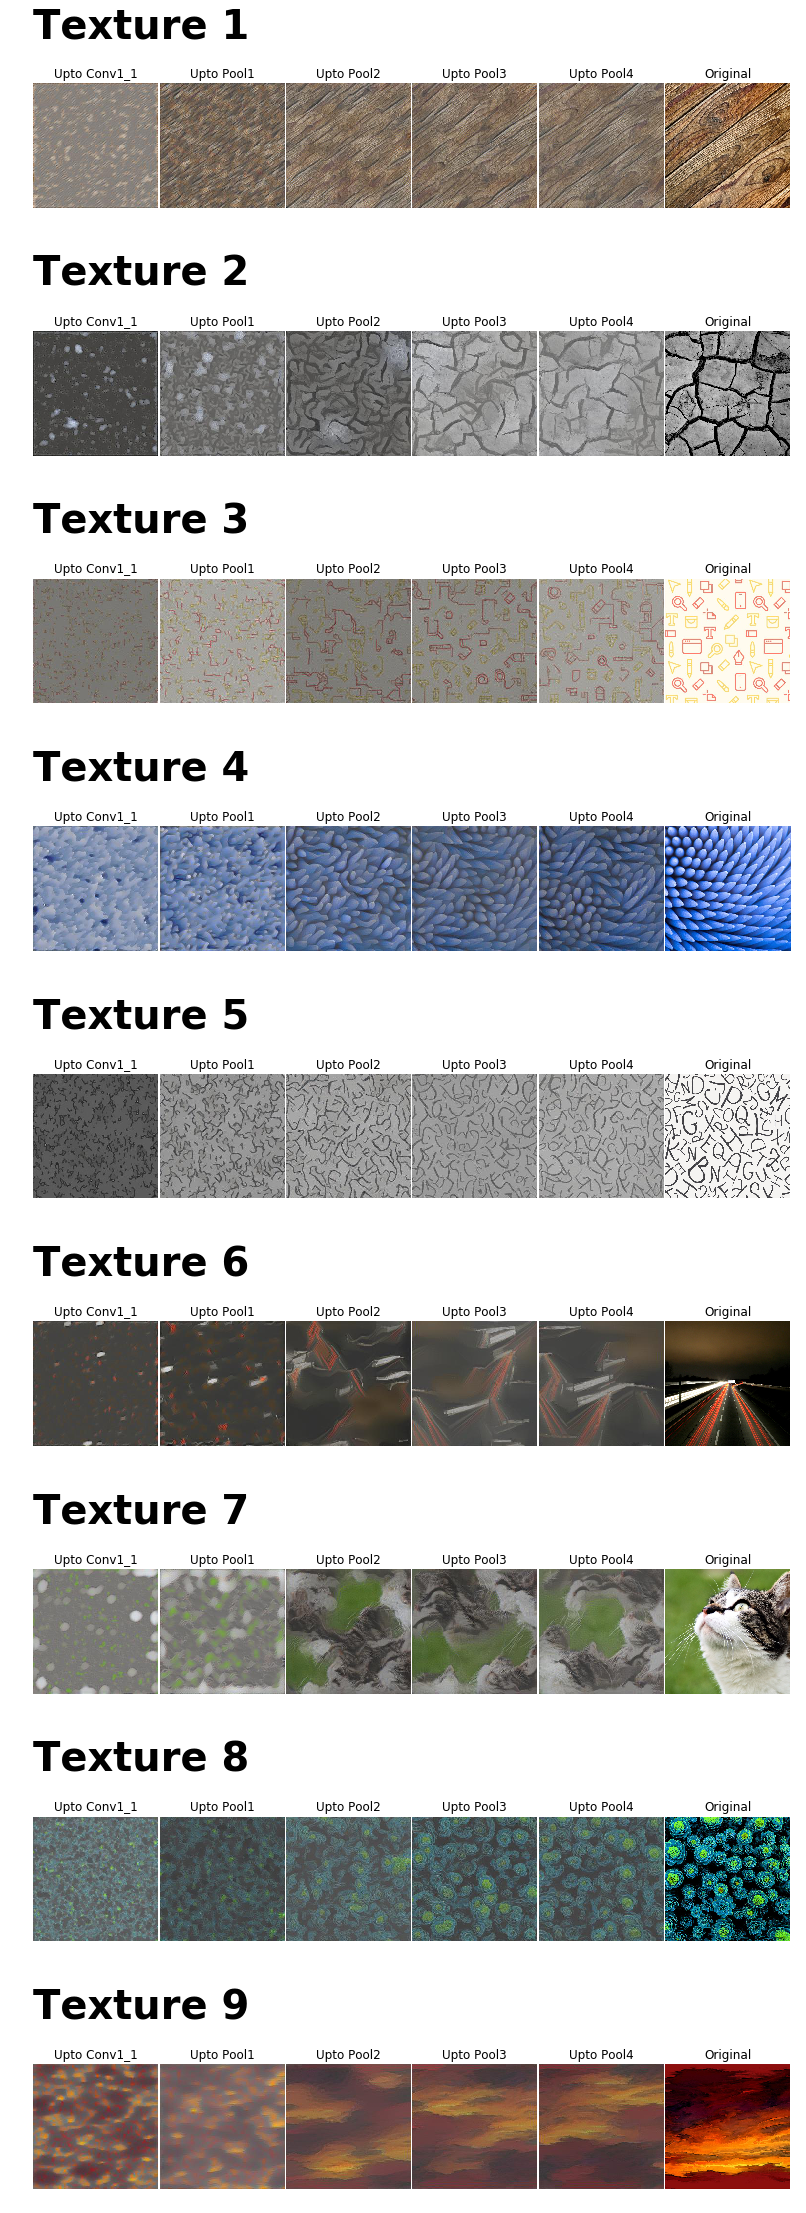

In [22]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

total_textures = 9
total_configs = 5

i = []
for m in range(total_textures):
    for n in range(total_configs):
        path = "./image_resources/outputs/Texture_" + str(m+1) + "_C" + str(n+1) + "_final.jpg"
        i.append(mpimg.imread(path))
    path = "./image_resources/original/texture_" + str(m+1) + ".jpg"
    i.append(mpimg.imread(path))

fig = plt.figure(figsize=(30, 30))

cols = 6
rows = 9

k = ["Upto Conv1_1", "Upto Pool1", "Upto Pool2", "Upto Pool3", "Upto Pool4", "Original"]
N = 1

for j in range(cols*rows):
    fig.add_subplot(rows, cols, j+1)
    if j % 6 == 0:
        plt.text(0, 0, "Texture " + str(N) + "\n", fontweight='bold', fontsize=40)
        N += 1
    plt.imshow(i[j])
    if j > 5:
        m = j % 6
    else:
        m = j
    plt.title(k[m])
    plt.axis('off')
    plt.tight_layout(h_pad=9, w_pad=-50)

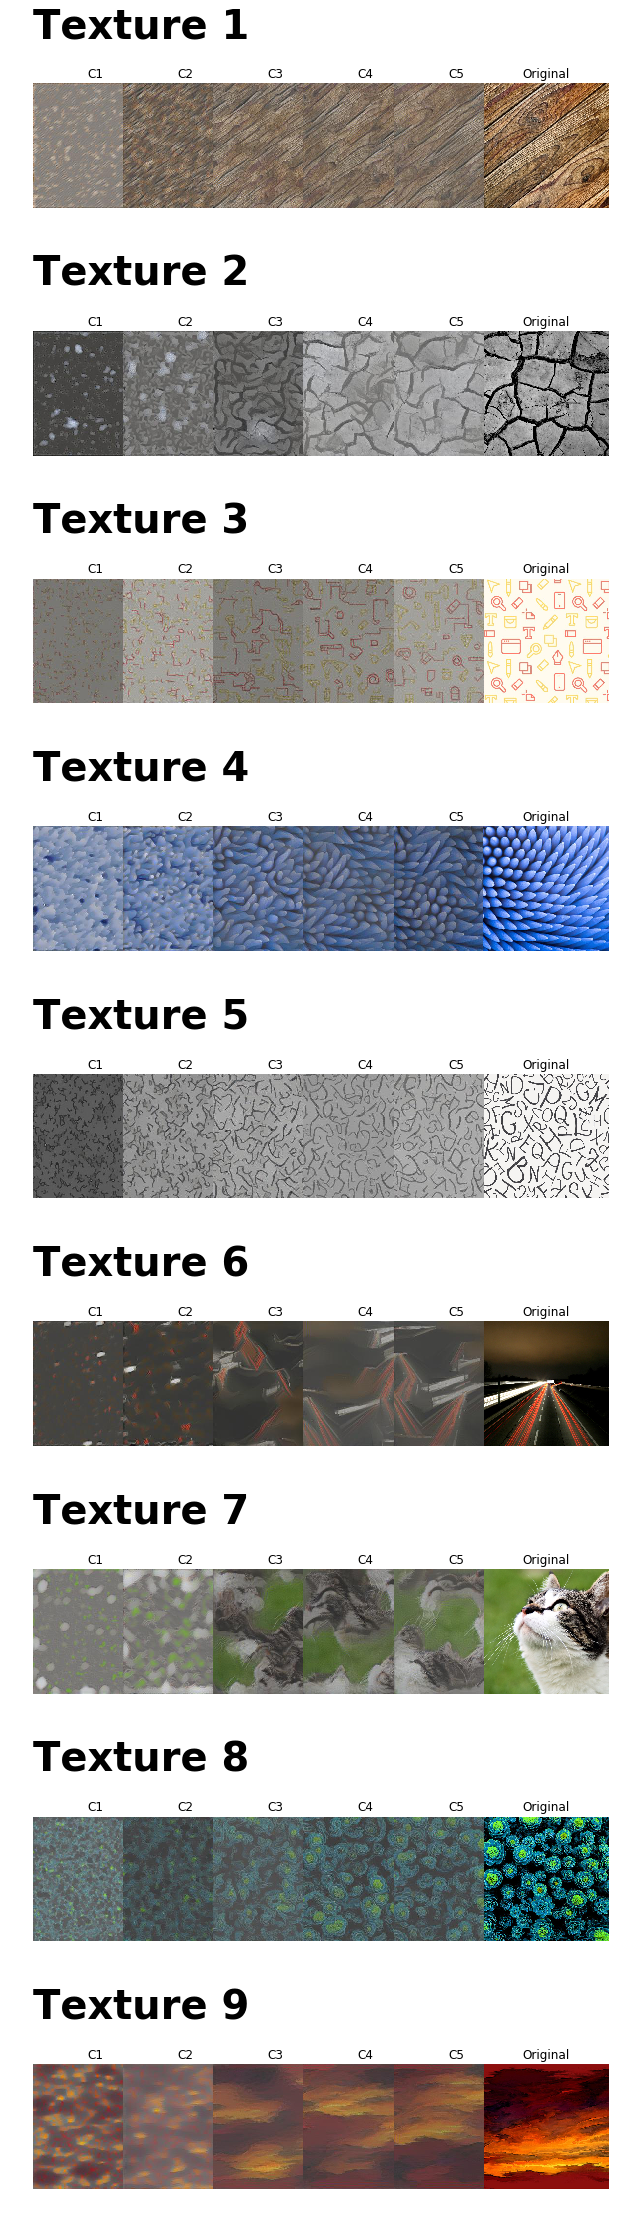

In [25]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

total_textures = 9
total_configs = 5

i = []
for m in range(total_textures):
    for n in range(total_configs):
        path = "./image_resources/outputs/Texture_" + str(m+1) + "_C" + str(n+1) + "_final.jpg"
        i.append(mpimg.imread(path))
    path = "./image_resources/original/texture_" + str(m+1) + ".jpg"
    i.append(mpimg.imread(path))

fig = plt.figure(figsize=(30, 30))

cols = 6
rows = 9

k = ["C1", "C2", "C3", "C4", "C5", "Original"]
N = 1

for j in range(cols*rows):
    fig.add_subplot(rows, cols, j+1)
    if j % 6 == 0:
        plt.text(0, 0, "Texture " + str(N) + "\n", fontweight='bold', fontsize=40)
        N += 1
    plt.imshow(i[j])
    if j > 5:
        m = j % 6
    else:
        m = j
    plt.title(k[m])
    plt.axis('off')
    plt.tight_layout(h_pad=9, w_pad=-60)

#### Note:
_Texture 3 and 5 are made with uniform random noise of 0 to 1 range as the colours arent achieved with range 0 to 0.2._
_Rest of the textures are made with uniform random noise of 0 to 0.2 range._

### Foot notes:
As we can see that the results are really good. As we dive deeper into the model and use the deeper layer for texture synthesis, we get images which are closely relevant to the original image.

However, in all the images the generated image dont have exact colour shade and it fails to generate the actual colour shade. But also that might be the problem with the post processing of the output not the problem of the training process. 